In [72]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import gaussian_blur

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [6]:
# ImageNet statistics for normalization (Standard for VGG/ResNet/Inception)
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [81]:
def deprocess_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.numpy().transpose((1, 2, 0))
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return Image.fromarray((image * 255).astype(np.uint8))
    

In [73]:
model_full = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)
model_full.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [95]:
def deepdream_gen(target_class, iterations=200, lr=0.1, blur_freq=6):
    """
    Generates an image from noise that maximizes a specific ImageNet class.
    """
    
    # Start with Random Noise
    # Shape: (1, 3, 224, 224) - Standard ImageNet input size
    image_tensor = torch.randn(1, 3, 224, 224, device=device)
    image_tensor.requires_grad_(True)
    
    print(f"Dreaming of class ID: {target_class}...")

    for i in range(iterations):
        model_full.zero_grad()
        
        # Forward pass through the entire network
        output = model_full(image_tensor)
        
        # Define Loss: Maximize the raw score (logit) of the target class
        # Note: We don't need Softmax here; raw logits work better for gradients
        loss = output[0, target_class] 
        
        loss.backward()

        # Gradient Ascent 
        with torch.no_grad():
            # Normalize gradients to prevent explosion
            grad = image_tensor.grad
            grad = grad / (torch.std(grad) + 1e-8)
            
            # Update image
            image_tensor += lr * grad
            
            # L2 Decay (keeps pixel values bounded, preventing saturation)
            image_tensor *= 0.995 
            
            # Regularization: Periodically blur to suppress high-freq noise
            if i % blur_freq == 0:
                image_tensor[:] = gaussian_blur(image_tensor, kernel_size=3, sigma=0.5)
                
            # Clear gradients for next step
            image_tensor.grad.zero_()

    return deprocess_image(image_tensor)

Dreaming of class ID: 130...


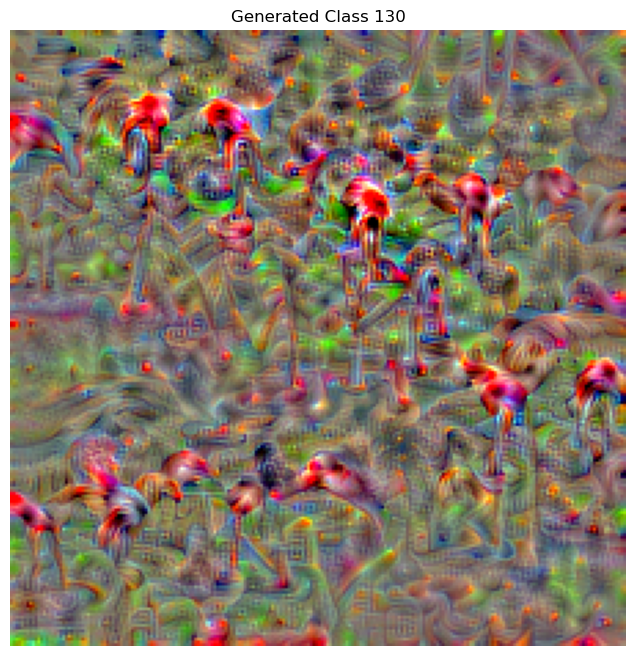

In [96]:
# Interesting ImageNet Class IDs:
# 130: Flamingo
# 291: Lion
# 951: Lemon
# 386: African Elephant
# 9: Ostrich
# imagenet_class_index.txt contains the class names with the class IDs

target_id = 130 # Flamingo
generated_img = deepdream_gen(target_id, iterations=200, lr=0.1)

plt.figure(figsize=(8, 8))
plt.title(f"Generated Class {target_id}")
plt.imshow(generated_img)
plt.axis('off')
plt.show()